In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten


# Supress info, warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
disease_types = ['COVID', 'non-COVID']

train_dir = data_dir = '/content/drive/MyDrive/CT scan'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])

    train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
train

,File,ID,Disease Type
0,COVID/Covid (221).png,0,COVID
1,COVID/Covid (1244).png,0,COVID
2,COVID/Covid (17).png,0,COVID
3,COVID/Covid (126).png,0,COVID
4,COVID/Covid (192).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (1193).png,1,non-COVID
2477,non-COVID/Non-Covid (1180).png,1,non-COVID
2478,non-COVID/Non-Covid (1161).png,1,non-COVID
2479,non-COVID/Non-Covid (1105).png,1,non-COVID


Then, the data are randomly shuffled to separate the training and test set, according to which the network will be trained and tested, respectively. The percentage of the training set corresponds to 80% of the data, while that of the test set, to the remaining 20% of the total data. In the pre-processing stage, the images are cropped to dimensions 224x224, categorized according to the class to which they belong and subjected to accidental alteration of some features, such as shift, inversion, focus, etc.

,File,ID,Disease Type
0,COVID/Covid (17).png,0,COVID
1,COVID/Covid (719).png,0,COVID
2,COVID/Covid (529).png,0,COVID
3,non-COVID/Non-Covid (162).png,1,non-COVID
4,COVID/Covid (79).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (502).png,1,non-COVID
2477,non-COVID/Non-Covid (281).png,1,non-COVID
2478,non-COVID/Non-Covid (914).png,1,non-COVID
2479,non-COVID/Non-Covid (74).png,1,non-COVID


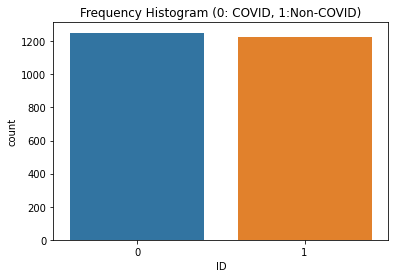

In [4]:
Seed = 40

train = train.sample(frac = 1, replace=False, random_state = Seed)

# Reset indices (row numbers)
train = train.reset_index(drop = True)

sns.countplot(x = "ID", data = train).set_title("Frequency Histogram (0: COVID, 1:Non-COVID)")
train

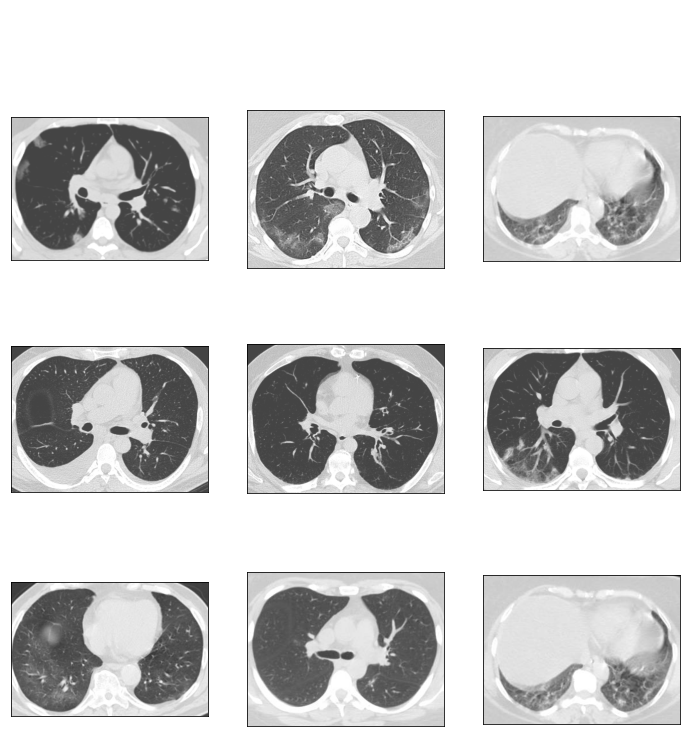

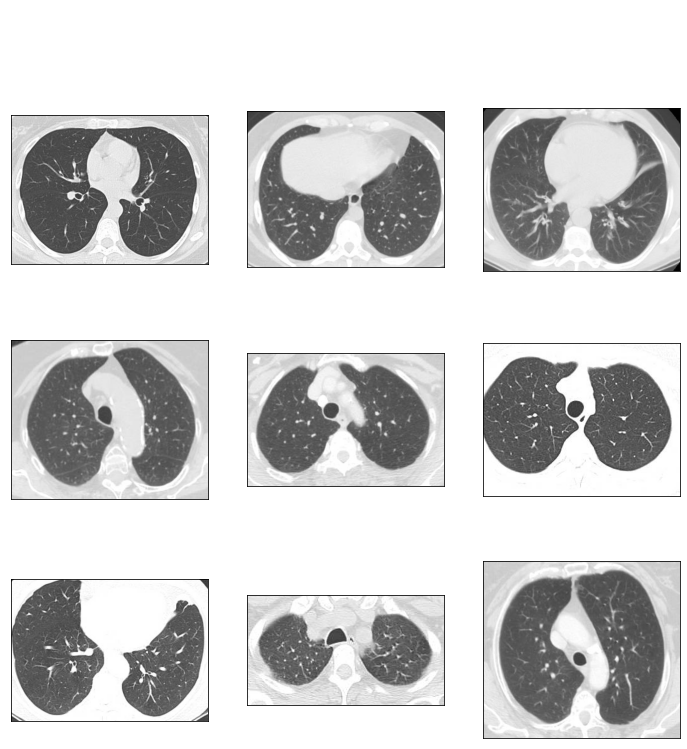

In [5]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    
    n = 0
    fig.suptitle(defect_types, fontsize = 22, color = "white")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('COVID', 3, 3)
plot_defects('non-COVID', 3, 3)

In [6]:
IMAGE_SIZE = 224

# OpenCV Function to load colored image
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

# OpenCV Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [7]:

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0   # Pixel normalization
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)

print(Y_train)


Train Shape: (2481, 224, 224, 3)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
# Dataframe split to train and validation set (80% train and 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_Train,
                                                  Y_train,
                                                  test_size = 0.2, # Percent 20% of the data is using as test set
                                                  random_state = Seed)

print(f'X_train:', X_train.shape)
print(f'X_val:', X_val.shape)
print(f'Y_train:', Y_train.shape)
print(f'Y_val:', Y_val.shape)

X_train: (1984, 224, 224, 3)
X_val: (497, 224, 224, 3)
Y_train: (1984, 2)
Y_val: (497, 2)


In [36]:
# Architectural function for Resnet50
def build_resnet50(IMAGE_SIZE, channels):

    resnet50 = ResNet50(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = resnet50(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    
    output = Dense(2, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model
    optimizer = Adam(learning_rate = 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model
    
    

In [37]:
channels = 3

model = build_resnet50(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 1,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically

datagen.fit(X_train)

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

ValueError: ignored

In [34]:
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically

datagen.fit(X_train)

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

NameError: ignored

In [ ]:

BATCH_SIZE = 32
EPOCHS = 50

# Fit of the model that includes the augmented images in terms of their characteristics
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (X_val, Y_val)

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

In [ ]:
# Accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
from keras.preprocessing import image

img = image.load_img('/content/drive/MyDrive/CT scan/COVID/Covid (1007).png', grayscale = False, target_size = (224, 224))
show_img = image.load_img('/content/drive/MyDrive/CT scan/COVID/Covid (1007).png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])